# About this notebook
- PyTorch TResNet starter code
- single fold
- 3 epochs

# Improvements maybe
- Use ArcFace or add triplet loss with cross entropy for score improvement

# acknowledgement
- Y.NAKAMA great [notebook](https://www.kaggle.com/yasufuminakama/herbarium-2020-pytorch-resnet18-train/notebook)
- Hussam Lawen great [discussion topic](https://www.kaggle.com/c/herbarium-2020-fgvc7/discussion/154186)

If this notebook is helpful, feel free to upvote :)

In [1]:
!pip install -q --upgrade wandb
!pip install -q ttach
!pip install  timm
!pip install git+https://github.com/mapillary/inplace_abn.git@v1.0.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 KB 1.4 MB/s eta 0:00:00
  Cloning https://github.com/mapillary/inplace_abn.git (to revision v1.0.12) to /tmp/pip-req-build-dajv2_2n
  Running command git clone --filter=blob:none --quiet https://github.com/mapillary/inplace_abn.git /tmp/pip-req-build-dajv2_2n
  Running command git checkout -q 24fc791e6d4796a1639e7a5dce6fa67377e51a3e
  Resolved https://github.com/mapillary/inplace_abn.git to commit 24fc791e6d4796a1639e7a5dce6fa67377e51a3e
  Preparing metadata (setup.py) ... - done
  Created wheel for inplace-abn: filename=inplace_abn-1.0.12-cp37-cp37m-linux_x86_64.whl size=3843262 sha256=cfa4eff300e42306215aee2b72a9dea48821a87c3086f06a9525b82770747b89
  Stored in directory: /tmp/pip-ephem-wheel-cache-_o2bpx2d/wheels/df/ad/aa/7ec1eff8c9b56fb3fab10471e91c80bdf3b52036bf47727bae
Successfully built inplace-abn


# Data Loading

In [2]:
import os
import gc
import numpy as np
import pandas as pd
from PIL import Image
import cv2 as cv
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 300

In [3]:
train = pd.read_csv('../input/herbarium-2022-pandas/train.csv')

In [4]:
train["genus_id"].value_counts()

422     24743
219     15192
1793    12256
912     10063
906      7135
        ...  
2537        7
1026        7
1370        6
2284        6
86          6
Name: genus_id, Length: 2564, dtype: int64

# Quick EDA

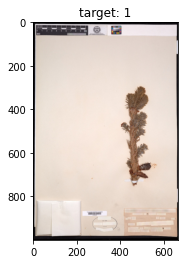

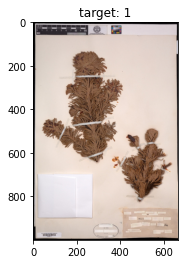

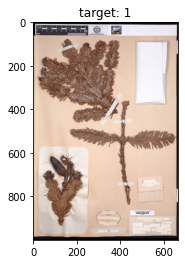

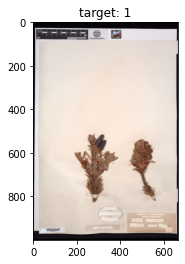

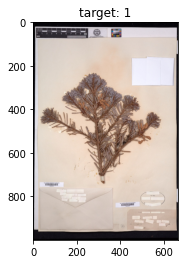

In [5]:
for i in range(5):
    image = cv.imread(train.loc[i, 'directory'])
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    target = train.loc[i, 'genus_id']
    plt.imshow(image)
    plt.title(f"target: {target}")
    plt.show()

In [6]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train['genus_id'])
train['genus_id'] = le.transform(train['genus_id'])

# Directory settings

In [7]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Configuration

In [8]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=128
    num_workers=8
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=4
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':3,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3
    }
    batch_size=32
    lr=1e-3
    weight_decay=1e-5
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["genus_id"].shape[0]
    nfolds=2
    trn_folds=[0]
    model_name='mobilenetv3_large_100'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d'
    train=True
    early_stop=True
    target_col="genus_id"
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [9]:
# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# W&B

In [10]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Herbarium 2022 Final", 
                 name="MobileNet_Final",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sasthas. Use `wandb login --relogin` to force relogin


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = f1_score(y_true, y_pred, average="macro")
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV schem

In [12]:
%%time
skf = StratifiedKFold(n_splits=CFG.nfolds, shuffle=True, random_state=CFG.seed)
for fold, (trn_idx, vld_idx) in enumerate(skf.split(train, train[CFG.target_col])):
    train.loc[vld_idx, "folds"] = int(fold)
train["folds"] = train["folds"].astype(int)

CPU times: user 1.32 s, sys: 18.4 ms, total: 1.34 s
Wall time: 1.34 s


# Dataset

In [13]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['directory'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        try:
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = Image.open(file_path)
            image = image.convert("RGB")
            image = np.array(image)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label


# Transforms

In [14]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose(
        [
           A.Resize(CFG.size, CFG.size),
           A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            A.Flip(p=0.05),
            
            A.Cutout(p=0.05),
            A.HorizontalFlip(p=0.05),
            A.VerticalFlip(p=0.05),
            A.Rotate(limit=180, p=0.05),
            A.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.05
            ),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.4,
                val_shift_limit=0.2, p=0.05
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.05
            ),
            ToTensorV2(p=1.0),
        ]
    )

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

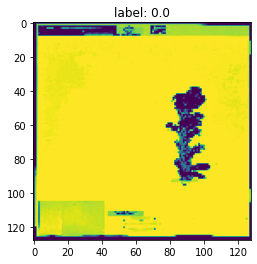

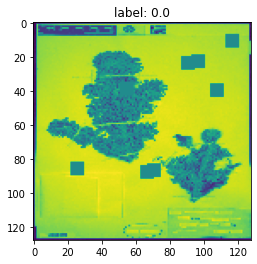

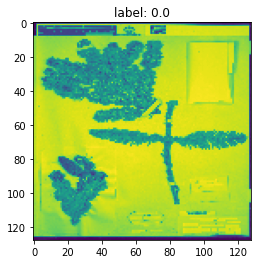

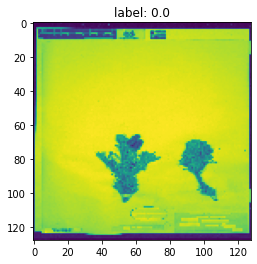

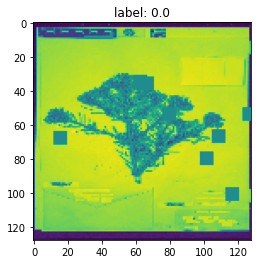

In [15]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(4, 4))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# Model

In [16]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=3)
        
        if cfg.model_name == 'tf_efficientnetv2_b0':
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, self.cfg.fc_dim)
        
        if cfg.model_name.split('_')[1] == "efficientnet_b0":
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, self.cfg.fc_dim)
            
        if cfg.model_name == 'resnext50_32x4d':
            self.in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(self.in_features, self.cfg.fc_dim)
            
        if cfg.model_name == 'resnet50_m':
            self.in_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(self.in_features, self.cfg.fc_dim)
        
        if cfg.model_name == 'mobilenetv3_large_100':
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, self.cfg.fc_dim)
            
        elif cfg.model_name.split('_')[0] == 'vit':
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, self.cfg.fc_dim)
        
        self.fc = nn.Linear(self.cfg.fc_dim, self.cfg.target_size)

    def forward(self, x):
        features = self.model(x)
        output = self.fc(features)
        return output

# Helper functions

In [17]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds, labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        preds.append(y_preds.argmax(1).to('cpu').numpy())
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train loop

In [18]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['folds'] != fold].index
    val_idx = folds[folds['folds'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds["genus_id"].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.reduce_params)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        
        #preds_label = np.argmax(preds, axis=1)
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss,
                   f"[fold{fold}] score": score})

        if score >= best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds_score': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds_loss': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
        
        
    valid_folds["preds_score"] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds_score']
    valid_folds["preds_loss"] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                      map_location=torch.device('cpu'))['preds_loss']
   

    return valid_folds

In [19]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds_score = result_df['preds_score'].values
        preds_loss = result_df['preds_loss'].values
        labels = result_df["genus_id"].values
        score = get_score(labels, preds_score)
        score_loss = get_score(labels, preds_loss)
        LOGGER.info(f'Score with best score weights: {score:<.4f}')
        LOGGER.info(f'Score with best loss weights: {score_loss:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.nfolds):
            if fold in CFG.trn_folds:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        
    wandb.finish()

In [20]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/mobilenetv3_large_100_ra-f55367f5.pth" to /root/.cache/torch/hub/checkpoints/mobilenetv3_large_100_ra-f55367f5.pth


Epoch: [1][0/13121] Elapsed 0m 10s (remain 2386m 46s) Loss: 13.6324(13.6324) Grad: 2.5050 LR: 0.001000  
Epoch: [1][100/13121] Elapsed 0m 41s (remain 89m 18s) Loss: 9.1204(9.8388) Grad: 5.2624 LR: 0.001000  
Epoch: [1][200/13121] Elapsed 1m 16s (remain 82m 26s) Loss: 6.9459(8.8408) Grad: 5.3321 LR: 0.001000  
Epoch: [1][300/13121] Elapsed 1m 51s (remain 79m 25s) Loss: 7.7728(8.3015) Grad: 5.5113 LR: 0.001000  
Epoch: [1][400/13121] Elapsed 2m 27s (remain 77m 50s) Loss: 6.9262(7.9291) Grad: 5.8976 LR: 0.001000  
Epoch: [1][500/13121] Elapsed 3m 1s (remain 76m 13s) Loss: 6.4773(7.6479) Grad: 5.9531 LR: 0.001000  
Epoch: [1][600/13121] Elapsed 3m 36s (remain 75m 6s) Loss: 5.3509(7.4163) Grad: 6.1356 LR: 0.001000  
Epoch: [1][700/13121] Elapsed 4m 11s (remain 74m 12s) Loss: 6.6713(7.2300) Grad: 6.7369 LR: 0.001000  
Epoch: [1][800/13121] Elapsed 4m 45s (remain 73m 14s) Loss: 6.2979(7.0823) Grad: 6.7768 LR: 0.001000  
Epoch: [1][900/13121] Elapsed 5m 20s (remain 72m 23s) Loss: 5.4910(6.9398

Epoch 1 - avg_train_loss: 4.0464  avg_val_loss: 2.6902  time: 8423s
Epoch 1 - Score: 0.2275
Epoch 1 - Save Best Score: 0.2275 Model
Epoch 1 - Save Best Loss: 2.6902 Model


Epoch: [2][0/13121] Elapsed 0m 3s (remain 871m 13s) Loss: 3.1935(3.1935) Grad: 7.0668 LR: 0.000731  
Epoch: [2][100/13121] Elapsed 0m 39s (remain 85m 20s) Loss: 2.4148(2.7802) Grad: 6.6014 LR: 0.000731  
Epoch: [2][200/13121] Elapsed 1m 14s (remain 79m 55s) Loss: 3.6667(2.7719) Grad: 8.2283 LR: 0.000731  
Epoch: [2][300/13121] Elapsed 1m 50s (remain 78m 45s) Loss: 3.1546(2.7945) Grad: 7.6999 LR: 0.000731  
Epoch: [2][400/13121] Elapsed 2m 27s (remain 77m 54s) Loss: 2.4051(2.7646) Grad: 7.6624 LR: 0.000731  
Epoch: [2][500/13121] Elapsed 3m 3s (remain 77m 0s) Loss: 2.1473(2.7687) Grad: 7.0308 LR: 0.000731  
Epoch: [2][600/13121] Elapsed 3m 38s (remain 75m 58s) Loss: 2.8008(2.7758) Grad: 7.4212 LR: 0.000731  
Epoch: [2][700/13121] Elapsed 4m 16s (remain 75m 36s) Loss: 2.9820(2.7680) Grad: 7.6832 LR: 0.000731  
Epoch: [2][800/13121] Elapsed 4m 52s (remain 74m 53s) Loss: 3.5258(2.7665) Grad: 8.6902 LR: 0.000731  
Epoch: [2][900/13121] Elapsed 5m 28s (remain 74m 14s) Loss: 2.6364(2.7726) Gr

Epoch 2 - avg_train_loss: 2.6106  avg_val_loss: 2.1503  time: 8571s
Epoch 2 - Score: 0.3437
Epoch 2 - Save Best Score: 0.3437 Model
Epoch 2 - Save Best Loss: 2.1503 Model


Epoch: [3][0/13121] Elapsed 0m 3s (remain 724m 12s) Loss: 2.1538(2.1538) Grad: 6.5436 LR: 0.000300  
Epoch: [3][100/13121] Elapsed 0m 39s (remain 84m 56s) Loss: 2.0838(2.1313) Grad: 7.0492 LR: 0.000300  
Epoch: [3][200/13121] Elapsed 1m 14s (remain 79m 47s) Loss: 2.0215(2.0521) Grad: 6.8945 LR: 0.000300  
Epoch: [3][300/13121] Elapsed 1m 48s (remain 77m 18s) Loss: 1.8463(2.0329) Grad: 5.9758 LR: 0.000300  
Epoch: [3][400/13121] Elapsed 2m 24s (remain 76m 37s) Loss: 1.7742(2.0188) Grad: 6.2666 LR: 0.000300  
Epoch: [3][500/13121] Elapsed 2m 59s (remain 75m 31s) Loss: 1.5482(1.9949) Grad: 5.9183 LR: 0.000300  
Epoch: [3][600/13121] Elapsed 3m 37s (remain 75m 26s) Loss: 1.7534(1.9787) Grad: 6.1450 LR: 0.000300  
Epoch: [3][700/13121] Elapsed 4m 12s (remain 74m 37s) Loss: 1.5243(1.9707) Grad: 5.8410 LR: 0.000300  
Epoch: [3][800/13121] Elapsed 4m 48s (remain 73m 55s) Loss: 2.3528(1.9601) Grad: 6.2875 LR: 0.000300  
Epoch: [3][900/13121] Elapsed 5m 23s (remain 73m 11s) Loss: 2.4935(1.9576) 

Epoch 3 - avg_train_loss: 1.8342  avg_val_loss: 1.5501  time: 8519s
Epoch 3 - Score: 0.4816
Epoch 3 - Save Best Score: 0.4816 Model
Epoch 3 - Save Best Loss: 1.5501 Model


Epoch: [4][0/13121] Elapsed 0m 3s (remain 804m 7s) Loss: 1.9761(1.9761) Grad: 6.8565 LR: 0.000052  
Epoch: [4][100/13121] Elapsed 0m 38s (remain 83m 43s) Loss: 0.7896(1.4552) Grad: 4.5395 LR: 0.000052  
Epoch: [4][200/13121] Elapsed 1m 15s (remain 80m 49s) Loss: 1.5810(1.4199) Grad: 6.0640 LR: 0.000052  
Epoch: [4][300/13121] Elapsed 1m 50s (remain 78m 38s) Loss: 1.1786(1.3912) Grad: 5.1826 LR: 0.000052  
Epoch: [4][400/13121] Elapsed 2m 26s (remain 77m 30s) Loss: 1.1541(1.3746) Grad: 4.9843 LR: 0.000052  
Epoch: [4][500/13121] Elapsed 3m 3s (remain 77m 2s) Loss: 1.1744(1.3734) Grad: 5.5614 LR: 0.000052  
Epoch: [4][600/13121] Elapsed 3m 38s (remain 75m 52s) Loss: 0.7612(1.3598) Grad: 4.7736 LR: 0.000052  
Epoch: [4][700/13121] Elapsed 4m 15s (remain 75m 27s) Loss: 1.1236(1.3510) Grad: 5.5170 LR: 0.000052  
Epoch: [4][800/13121] Elapsed 4m 50s (remain 74m 27s) Loss: 1.5979(1.3523) Grad: 5.8896 LR: 0.000052  
Epoch: [4][900/13121] Elapsed 5m 26s (remain 73m 41s) Loss: 0.7309(1.3412) Gra

Epoch 4 - avg_train_loss: 1.2228  avg_val_loss: 1.1658  time: 8480s
Epoch 4 - Score: 0.5871
Epoch 4 - Save Best Score: 0.5871 Model
Epoch 4 - Save Best Loss: 1.1658 Model
========== fold: 0 result ==========
Score with best score weights: 0.5871
Score with best loss weights: 0.5871
========== CV ==========
Score with best score weights: 0.5871
Score with best loss weights: 0.5871


[fold0] avg_train_loss,█▄▃▁
[fold0] avg_val_loss,█▆▃▁
[fold0] epoch,▁▃▆█
[fold0] loss,█▇▆▄▅▅▄▄▅▄▃▃▃▃▄▃▃▄▃▃▂▄▂▂▂▃▃▂▂▄▂▂▁▂▂▂▁▁▂▂
[fold0] lr,██████████▆▆▆▆▆▆▆▆▆▆▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁
[fold0] score,▁▃▆█
[fold0] avg_train_loss,1.22279
[fold0] avg_val_loss,1.16575
[fold0] epoch,4
[fold0] loss,0.91802
[fold0] lr,5e-05
